Imports

In [1]:
import os
import sys
import datetime as dt

import numpy as np
import pandas as pd
import gym
import quantstats as qs
import matplotlib.pyplot as plt

sys.path.append(os.path.join(".."))
import gym_anytrading

from stable_baselines3.common.vec_env import DummyVecEnv

C:\Users\olith\AppData\Local\Programs\Python\Python39\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


Create environment

In [2]:
TICKERS = ["NESZ", "CIMB", "MAY", "KLK"]
df = {}
directions_df = {}
for ticker in TICKERS:
    df[ticker] = pd.read_csv(os.path.join("day_data", f"{ticker} MK Equity.csv"), parse_dates=True, index_col="Dates")
    d_df =  pd.read_csv(os.path.join("directions", f"Directions {ticker}.csv"), parse_dates=True, index_col="Dates")
    direction_start = d_df.index.get_loc(dt.datetime(2018, 1, 1)) + 1
    direction_end = d_df.index.get_loc(dt.datetime(2020, 1, 1))
    directions_df[ticker] = d_df.iloc[direction_start:direction_end]

window_size = 30

val_start = df[TICKERS[0]].index.get_loc(dt.datetime(2018, 1, 1))
val_end = df[TICKERS[0]].index.get_loc(dt.datetime(2020, 1, 1))
print(val_start, val_end)

env_maker_val = lambda: gym.make(
    "daily-v0",
    df=df,
    window_size=window_size,
    frame_bound=(val_start, val_end),
    bankroll=100000.
)

env_val = DummyVecEnv([env_maker_val])

4695 5217
NESZ
CIMB
MAY
KLK
Continuous action space


# Buy and hold baseline

In [3]:
env = env_maker_val()
observation = env.reset()

c = 0
cash_holding = []
while True:
    c += 1
    action = np.array([0, 1, 1, 1, 1])
    observation, reward, done, info = env.step(action)
    cash_holding.append(info["position"][0] / info["net_worth"])

    if done:
        print("Info:", info)
        print("Iterations:", c)
        break

print("Average cash:", np.mean(cash_holding) * 100)

NESZ
CIMB
MAY
KLK
Continuous action space
Info: {'total_reward': 1125.8399999999879, 'total_profit': 1125.8399999999879, 'position': array([  50.71,  173.  , 4831.  , 2942.  , 1022.  ]), 'delta': array([ -1.8,   1. ,  24. , -17. ,  -5. ]), 'net_worth': 101125.84000000014}
Iterations: 521
Average cash: 0.08804583326709457


                           Strategy
-------------------------  ----------
Start Period               2018-01-03
End Period                 2019-12-31
Risk-Free Rate             0.0%
Time in Market             94.0%

Cumulative Return          2.46%
CAGR﹪                     1.23%

Sharpe                     0.17
Smart Sharpe               0.16
Sortino                    0.23
Smart Sortino              0.21
Sortino/√2                 0.16
Smart Sortino/√2           0.15
Omega                      1.03

Max Drawdown               -18.95%
Longest DD Days            638
Volatility (ann.)          9.58%
Calmar                     0.06
Skew                       -0.44
Kurtosis                   3.36

Expected Daily %           0.0%
Expected Monthly %         0.1%
Expected Yearly %          1.22%
Kelly Criterion            1.62%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.99%
Expected Shortfall (cVaR)  -0.99%

Gain/Pain Ratio            0.03
Gain/Pain (1M)             0.13



None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-04-02,2019-10-09,2019-12-31,638,-18.954282,-18.525542
2,2018-03-14,2018-03-20,2018-03-30,16,-5.304625,-4.881084
3,2018-02-05,2018-02-06,2018-02-19,14,-2.164326,-1.535031
4,2018-03-01,2018-03-01,2018-03-02,1,-0.482770,0.000000
5,2018-01-09,2018-01-10,2018-01-12,3,-0.347100,-0.344327


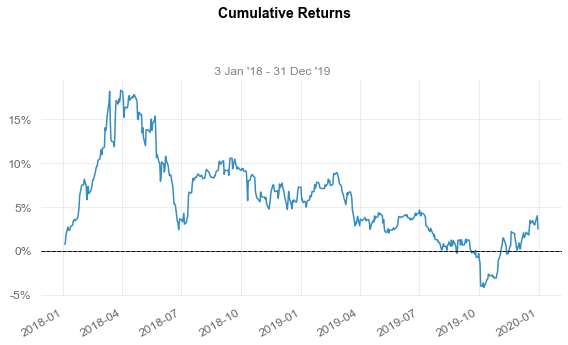

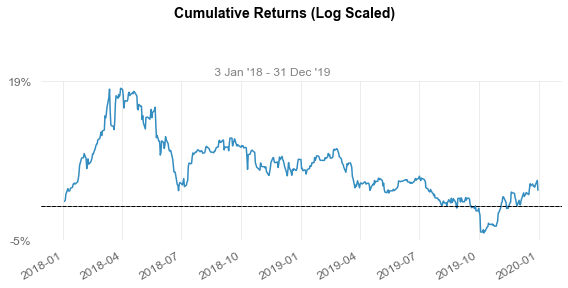

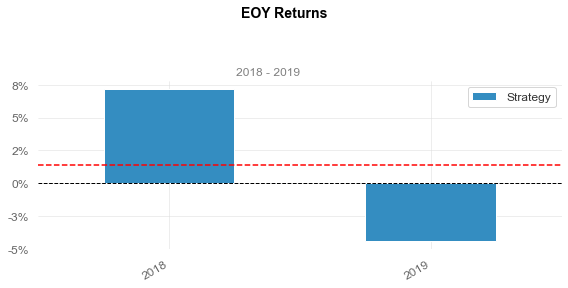

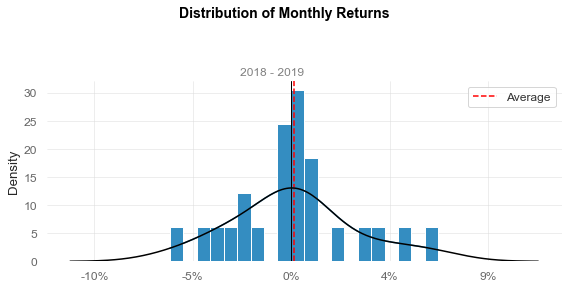

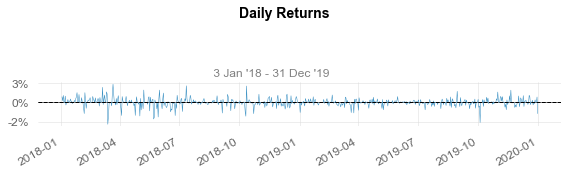

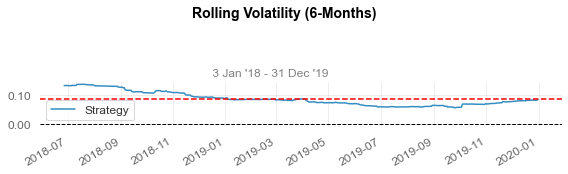

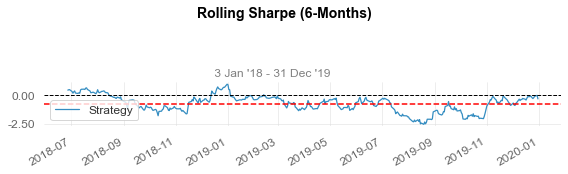

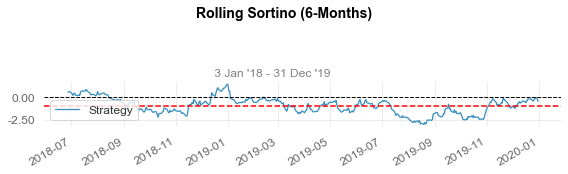

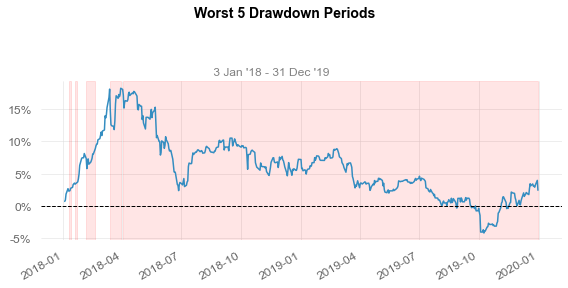

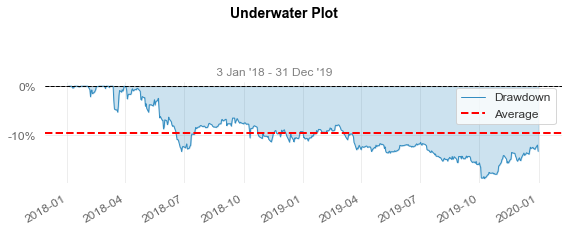

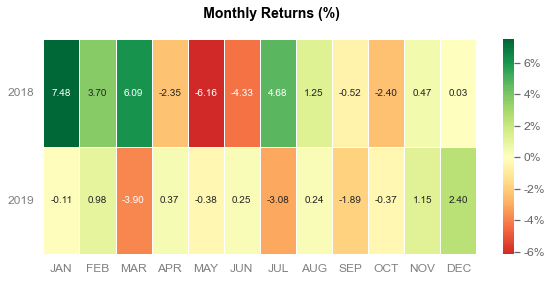

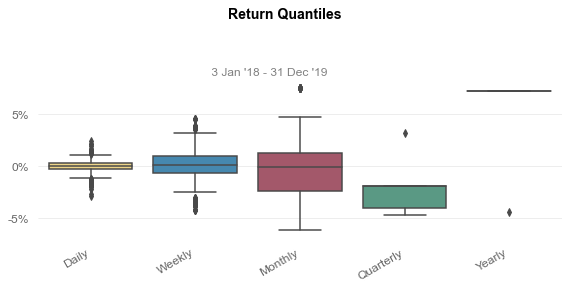

In [4]:
qs.extend_pandas()
new_worth = pd.Series(env.history["net_worth"], index=df[TICKERS[0]].index[val_start+1:val_end])
returns = new_worth.pct_change().iloc[1:]
qs.reports.full(returns)

# Momentum baseline

In [5]:
env = env_maker_val()
observation = env.reset()

c = 0
cash_holding = []
stock_ts = 0
while True:
    c += 1
    action = np.zeros(len(TICKERS) + 1, dtype=np.float)
    for i in range(len(TICKERS)):
        if observation[-1, i, 1] > 0:
            action[i + 1] = 1.

    if np.sum(action[1:]) == 0:
        action[0] = 1.
    else:
        action[0] = 0.
        stock_ts += 1

    observation, reward, done, info = env.step(action)
    cash_holding.append(info["position"][0] / info["net_worth"])

    if done:
        print("Info:", info)
        print("Iterations:", c)
        break

print("Average cash:", np.mean(cash_holding) * 100)
print("Time steps with stock:", stock_ts / c * 100)

NESZ
CIMB
MAY
KLK
Continuous action space
Info: {'total_reward': -4454.419999999895, 'total_profit': -4454.419999999895, 'position': array([ 114.38,  328.  , 9168.  ,    0.  ,    0.  ]), 'delta': array([   108.64,    328.  ,   9168.  , -11166.  ,      0.  ]), 'net_worth': 95545.57999999997}
Iterations: 521
Average cash: 22.881260201183906
Time steps with stock: 77.15930902111324


                           Strategy
-------------------------  ----------
Start Period               2018-01-03
End Period                 2019-12-31
Risk-Free Rate             0.0%
Time in Market             69.0%

Cumulative Return          -2.97%
CAGR﹪                     -1.5%

Sharpe                     -0.09
Smart Sharpe               -0.08
Sortino                    -0.12
Smart Sortino              -0.11
Sortino/√2                 -0.09
Smart Sortino/√2           -0.08
Omega                      0.98

Max Drawdown               -22.32%
Longest DD Days            657
Volatility (ann.)          10.2%
Calmar                     -0.07
Skew                       -1.09
Kurtosis                   11.86

Expected Daily %           -0.01%
Expected Monthly %         -0.13%
Expected Yearly %          -1.5%
Kelly Criterion            -0.98%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.06%
Expected Shortfall (cVaR)  -1.06%

Gain/Pain Ratio            -0.02
Gain/Pain (1M)    

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-03-14,2019-10-09,2019-12-31,657,-22.318214,-22.005300
2,2018-02-06,2018-02-09,2018-02-15,9,-1.427664,-1.262925
3,2018-02-28,2018-03-01,2018-03-02,2,-1.168480,-0.685846
4,2018-01-09,2018-01-11,2018-01-15,6,-0.538388,-0.459208
5,2018-01-19,2018-01-19,2018-01-22,3,-0.370500,0.000000


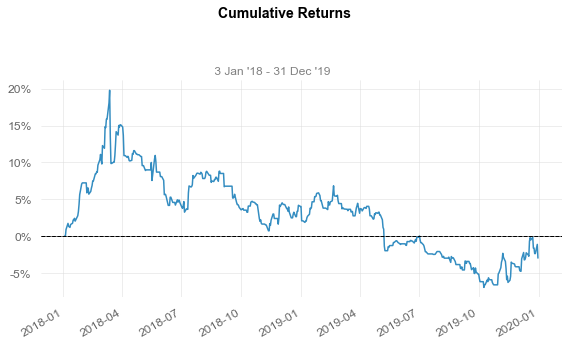

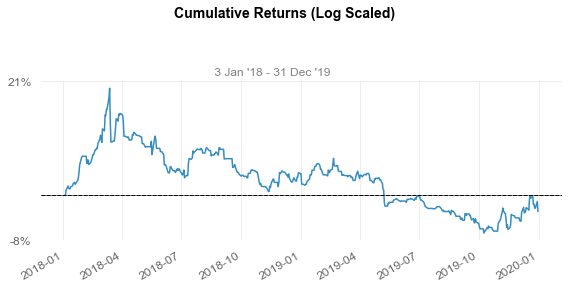

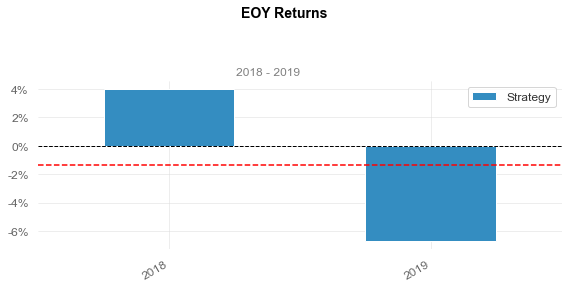

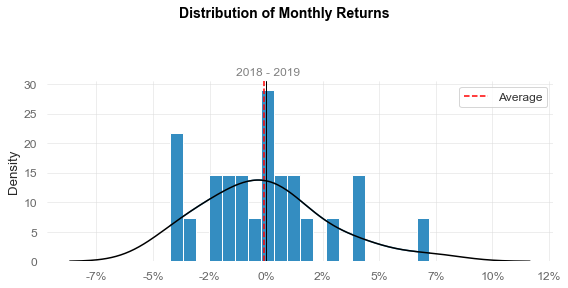

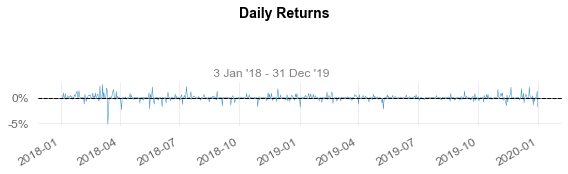

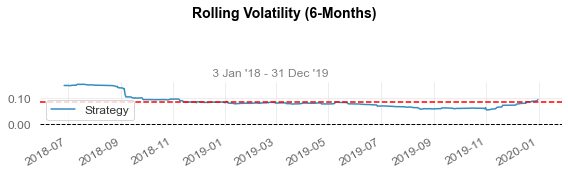

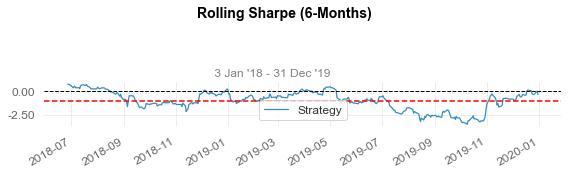

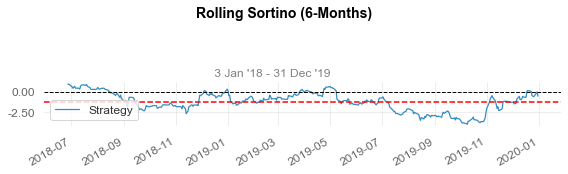

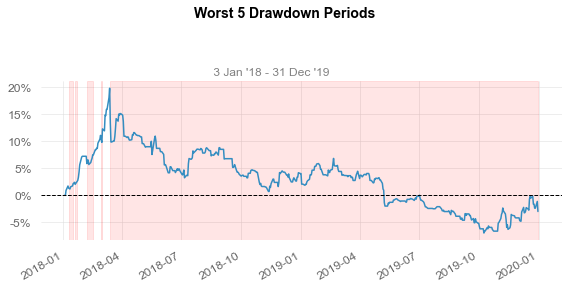

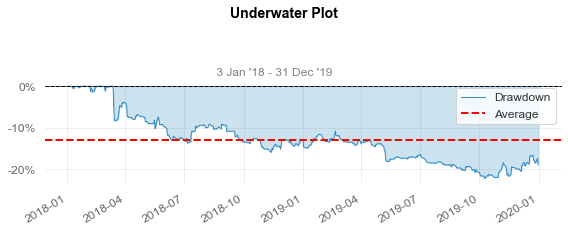

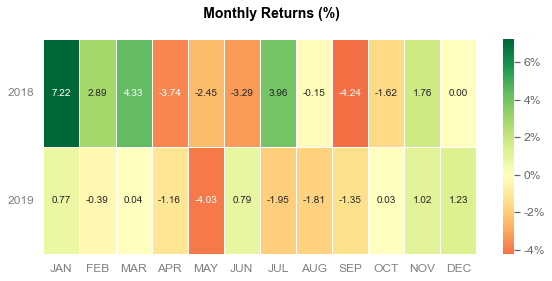

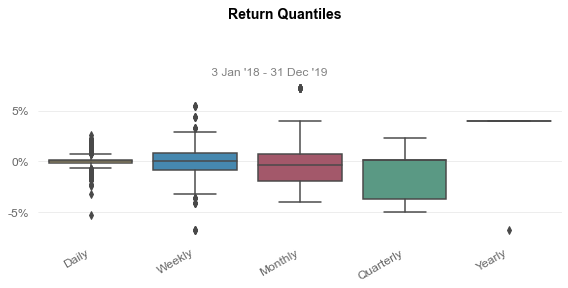

In [6]:
qs.extend_pandas()
new_worth = pd.Series(env.history["net_worth"], index=df[TICKERS[0]].index[val_start+1:val_end])
returns = new_worth.pct_change().iloc[1:]
qs.reports.full(returns)

# Mean Reversion Baseline

In [7]:
env = env_maker_val()
observation = env.reset()

c = 0
cash_holding = []
stock_ts = 0
while True:
    c += 1
    action = np.zeros(len(TICKERS) + 1, dtype=np.float)
    for i in range(len(TICKERS)):
        if observation[-1, i, 1] < 0:
            action[i + 1] = 1.

    if np.sum(action[1:]) == 0:
        action[0] = 1.
    else:
        action[1] = 0.
        stock_ts += 1

    observation, reward, done, info = env.step(action)
    cash_holding.append(info["position"][0] / info["net_worth"])

    if done:
        print("Info:", info)
        print("Iterations:", c)
        break

print("Average cash:", np.mean(cash_holding) * 100)
print("Stock TS:", stock_ts / c * 100)

NESZ
CIMB
MAY
KLK
Continuous action space
Info: {'total_reward': -12379.389999999996, 'total_profit': -12379.389999999996, 'position': array([2.3700e+00, 0.0000e+00, 0.0000e+00, 1.0141e+04, 0.0000e+00]), 'delta': array([-2.0900e+00,  0.0000e+00, -1.6653e+04,  1.0141e+04,  0.0000e+00]), 'net_worth': 87620.60999999997}
Iterations: 521
Average cash: 32.637540806855185
Stock TS: 73.70441458733205


                           Strategy
-------------------------  ----------
Start Period               2018-01-03
End Period                 2019-12-31
Risk-Free Rate             0.0%
Time in Market             60.0%

Cumulative Return          -12.38%
CAGR﹪                     -6.42%

Sharpe                     -0.48
Smart Sharpe               -0.47
Sortino                    -0.62
Smart Sortino              -0.6
Sortino/√2                 -0.44
Smart Sortino/√2           -0.43
Omega                      0.88

Max Drawdown               -18.24%
Longest DD Days            587
Volatility (ann.)          11.78%
Calmar                     -0.35
Skew                       -1.57
Kurtosis                   18.05

Expected Daily %           -0.03%
Expected Monthly %         -0.55%
Expected Yearly %          -6.39%
Kelly Criterion            -6.82%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.24%
Expected Shortfall (cVaR)  -1.24%

Gain/Pain Ratio            -0.12
Gain/Pain (1M) 

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-05-23,2019-10-04,2019-12-31,587,-18.239219,-17.839193
2,2018-04-13,2018-05-07,2018-05-22,39,-4.816968,-3.390020
3,2018-03-22,2018-04-04,2018-04-11,20,-1.146739,-0.859538
4,2018-03-05,2018-03-07,2018-03-12,7,-0.823119,-0.741450
5,2018-03-15,2018-03-16,2018-03-20,5,-0.394091,-0.276227


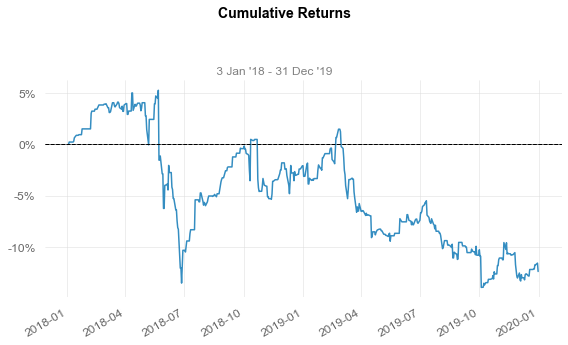

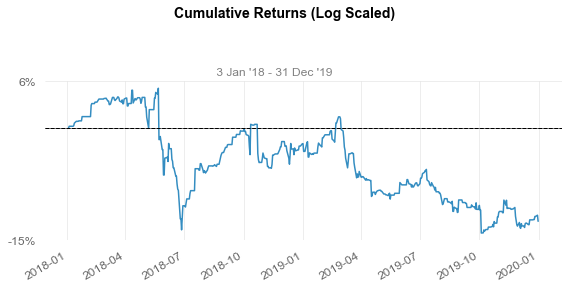

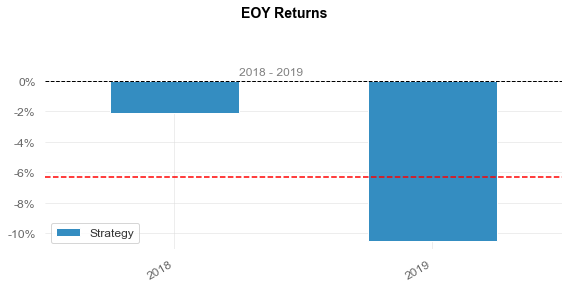

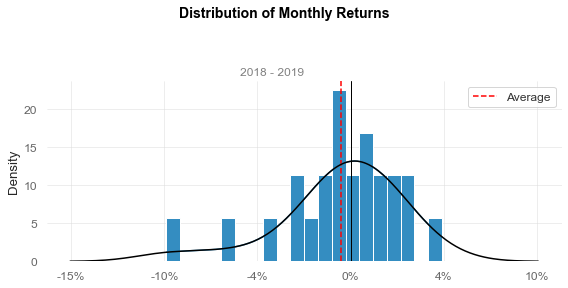

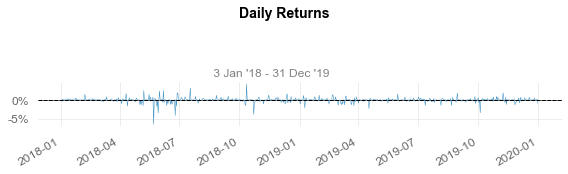

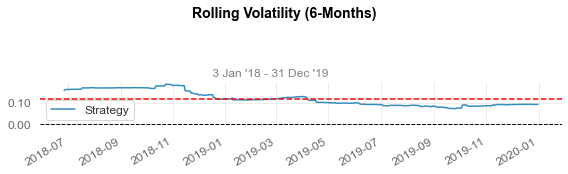

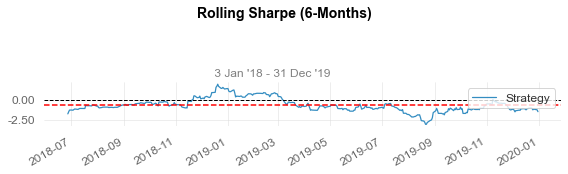

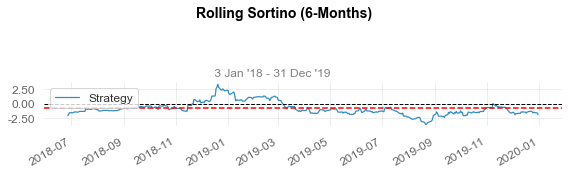

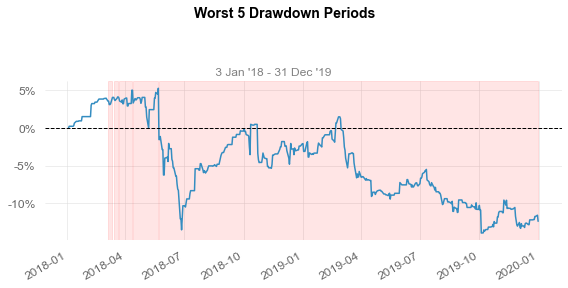

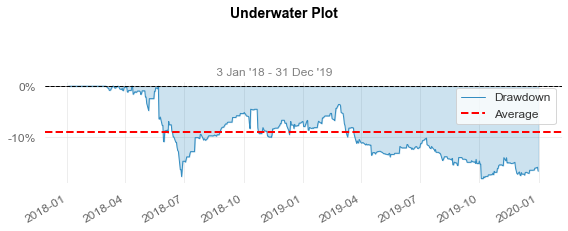

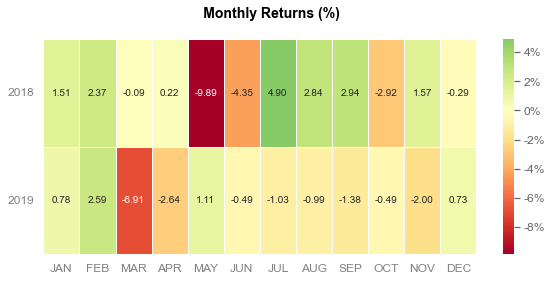

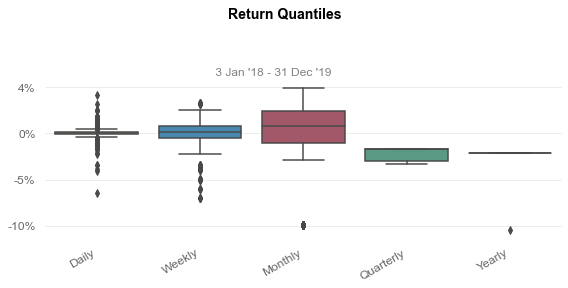

In [8]:
qs.extend_pandas()
new_worth = pd.Series(env.history["net_worth"], index=df[TICKERS[0]].index[val_start+1:val_end])
returns = new_worth.pct_change().iloc[1:]
qs.reports.full(returns)

# RSI 70 / 30 baseline

In [9]:
env = env_maker_val()
observation = env.reset()

c = 0
action = np.zeros(len(TICKERS) + 1, dtype=np.float)
cash_holding = []
stock_ts = 0
while True:
    for i, ticker in enumerate(TICKERS):
        if df[ticker].iloc[val_start + c].RSI_14D > 70.:
            action[i + 1] = 1.
        elif df[ticker].iloc[val_start + c].RSI_14D < 30:
            action[i + 1] = 0.

    if np.sum(action[1:]) > 0:
        action[0] = 0
        stock_ts += 1
    else:
        action[0] = 1

    c += 1
    observation, reward, done, info = env.step(action)
    cash_holding.append(info["position"][0] / info["net_worth"])

    if done:
        print("Info:", info)
        print("Iterations:", c)
        break


print("Average cash:", np.mean(cash_holding) * 100)
print("Time steps with stock:", stock_ts / c * 100)

NESZ
CIMB
MAY
KLK
Continuous action space
Info: {'total_reward': 4010.1299999999896, 'total_profit': 4010.1299999999896, 'position': array([  44.34,  178.  , 4969.  , 3026.  , 1051.  ]), 'delta': array([ -7.11,   1.  ,  25.  , -17.  ,  -5.  ]), 'net_worth': 104010.13000000018}
Iterations: 521
Average cash: 5.0350788881721025
Time steps with stock: 95.00959692898272


                           Strategy
-------------------------  ----------
Start Period               2018-01-03
End Period                 2019-12-31
Risk-Free Rate             0.0%
Time in Market             82.0%

Cumulative Return          5.84%
CAGR﹪                     2.89%

Sharpe                     0.33
Smart Sharpe               0.33
Sortino                    0.45
Smart Sortino              0.44
Sortino/√2                 0.32
Smart Sortino/√2           0.31
Omega                      1.07

Max Drawdown               -14.6%
Longest DD Days            638
Volatility (ann.)          9.72%
Calmar                     0.2
Skew                       -0.56
Kurtosis                   3.54

Expected Daily %           0.01%
Expected Monthly %         0.24%
Expected Yearly %          2.88%
Kelly Criterion            3.38%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.99%
Expected Shortfall (cVaR)  -0.99%

Gain/Pain Ratio            0.07
Gain/Pain (1M)             0.36



None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-04-02,2019-10-09,2019-12-31,638,-14.597783,-14.180231
2,2018-03-14,2018-03-20,2018-03-30,16,-5.305626,-4.881001
3,2018-02-05,2018-02-06,2018-02-19,14,-2.540691,-1.992440
4,2018-01-09,2018-01-09,2018-01-15,6,-0.538621,-0.489775
5,2018-03-01,2018-03-01,2018-03-02,1,-0.485862,0.000000


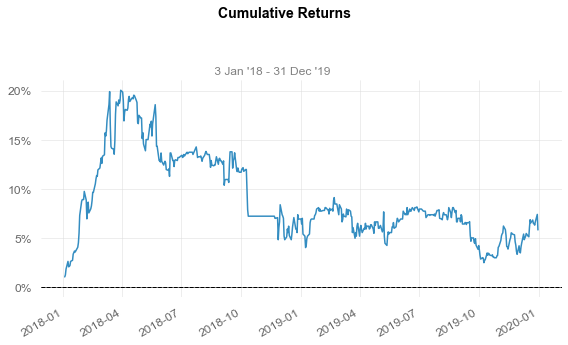

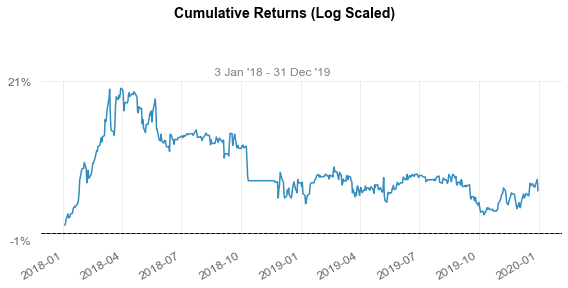

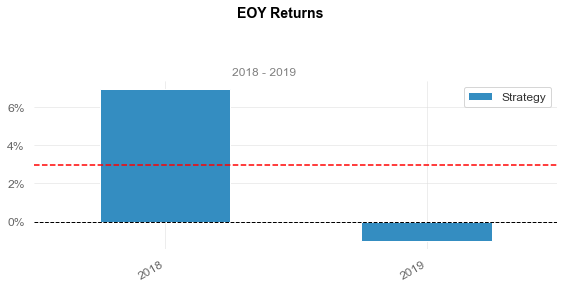

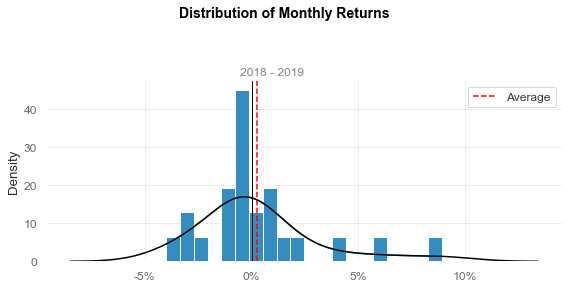

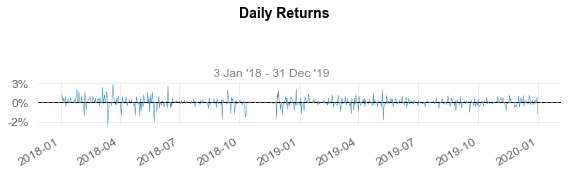

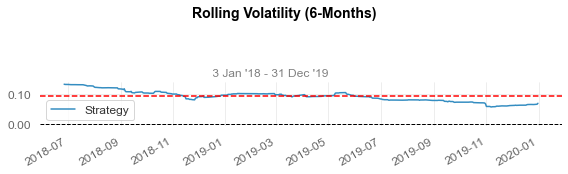

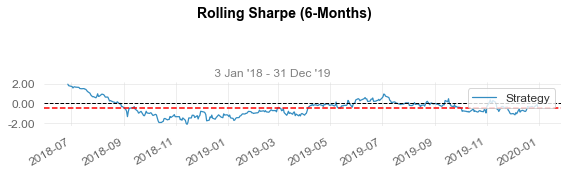

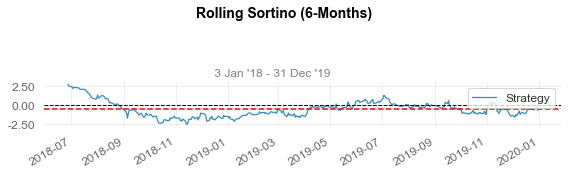

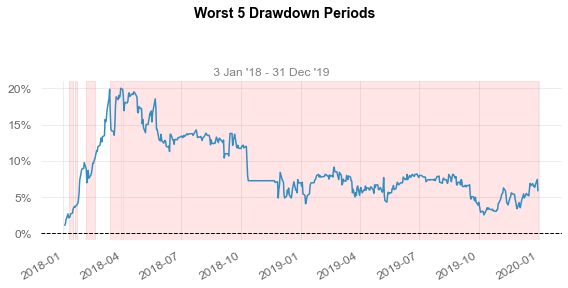

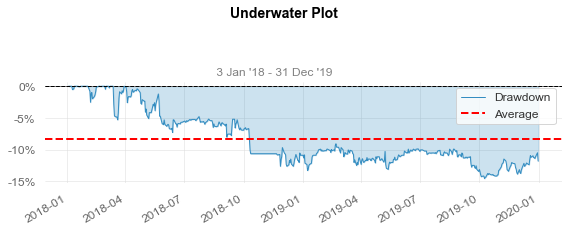

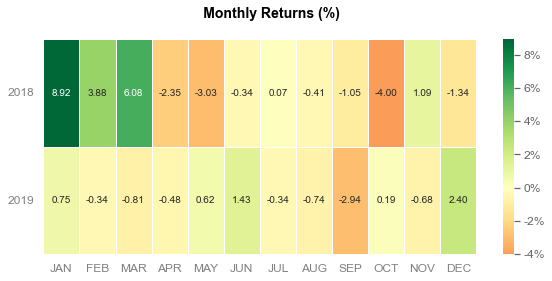

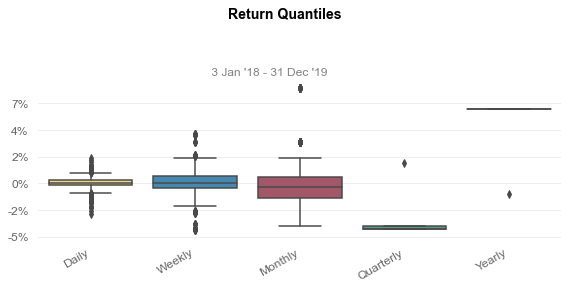

In [10]:
qs.extend_pandas()
new_worth = pd.Series(env.history["net_worth"], index=df[TICKERS[0]].index[val_start+1:val_end])
returns = new_worth.pct_change().iloc[1:]
qs.reports.full(returns)

# Average Model Baseline

In [11]:
env = env_maker_val()
observation = env.reset()

c = 0
cash_holding = []
stock_ts = 0
while True:
    action = np.zeros(len(TICKERS) + 1, dtype=np.float)
    for i, ticker in enumerate(TICKERS):
        if directions_df[ticker].iloc[c].AVG == 1.:
            action[i + 1] = 1.

    if np.sum(action[1:]) > 0:
        action[0] = 0
        stock_ts += 1
    else:
        action[0] = 1

    c += 1
    observation, reward, done, info = env.step(action)
    cash_holding.append(info["position"][0] / info["net_worth"])

    if done:
        print("Info:", info)
        print("Iterations:", c)
        break


print("Average cash:", np.mean(cash_holding) * 100)
print("Time steps with stock:", stock_ts / c * 100)

NESZ
CIMB
MAY
KLK
Continuous action space
Info: {'total_reward': 3754.130000000074, 'total_profit': 3754.130000000074, 'position': array([  23.03,    0.  , 6626.  , 4035.  , 1401.  ]), 'delta': array([ 12.04,   0.  ,  46.  , -15.  ,  -5.  ]), 'net_worth': 103754.13000000002}
Iterations: 521
Average cash: 5.240098960476377
Time steps with stock: 94.81765834932821


                           Strategy
-------------------------  ----------
Start Period               2018-01-03
End Period                 2019-12-31
Risk-Free Rate             0.0%
Time in Market             86.0%

Cumulative Return          5.07%
CAGR﹪                     2.51%

Sharpe                     0.27
Smart Sharpe               0.25
Sortino                    0.35
Smart Sortino              0.32
Sortino/√2                 0.25
Smart Sortino/√2           0.22
Omega                      1.06

Max Drawdown               -22.14%
Longest DD Days            657
Volatility (ann.)          10.88%
Calmar                     0.11
Skew                       -1.4
Kurtosis                   6.46

Expected Daily %           0.01%
Expected Monthly %         0.21%
Expected Yearly %          2.5%
Kelly Criterion            3.17%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.12%
Expected Shortfall (cVaR)  -1.12%

Gain/Pain Ratio            0.06
Gain/Pain (1M)             0.23


None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-03-14,2018-12-11,2019-12-31,657,-22.138250,-21.055380
2,2018-02-05,2018-02-09,2018-02-21,16,-2.697773,-2.464980
3,2018-03-05,2018-03-08,2018-03-09,4,-0.897566,-0.672610
4,2018-01-09,2018-01-10,2018-01-12,3,-0.346969,-0.344007
5,2018-01-19,2018-01-19,2018-01-22,3,-0.154068,0.000000


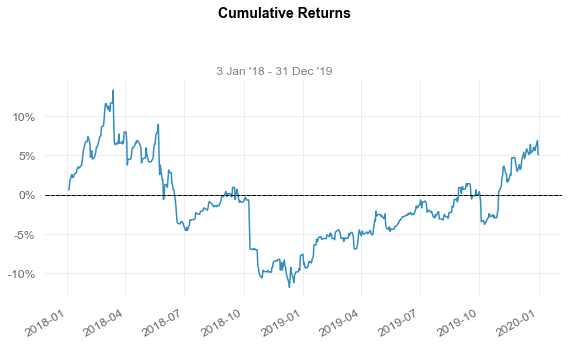

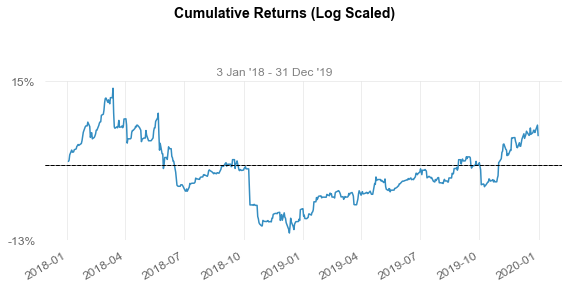

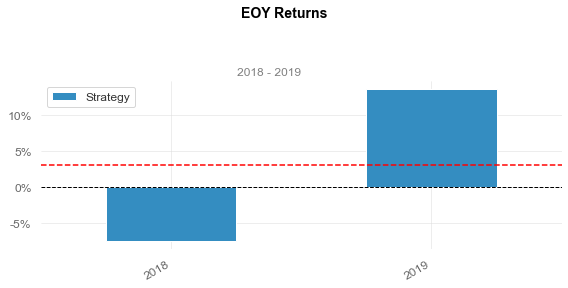

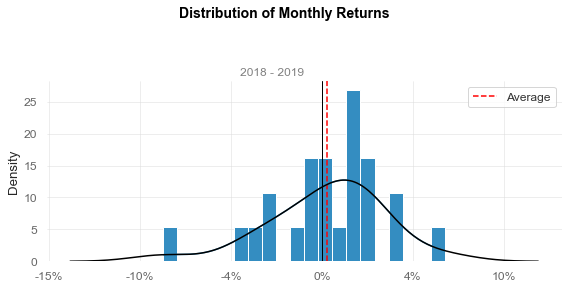

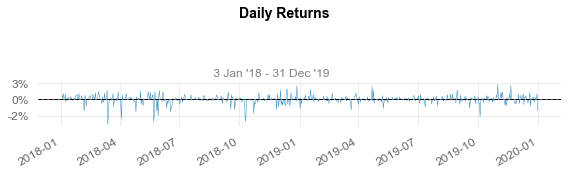

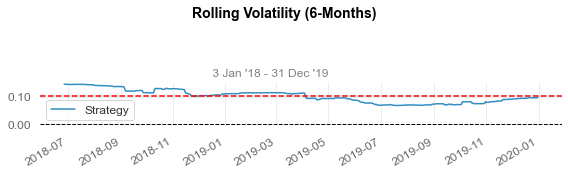

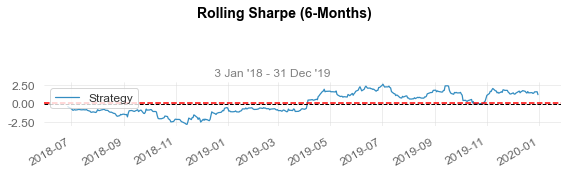

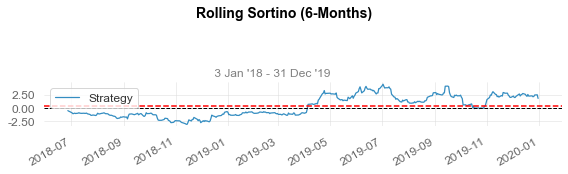

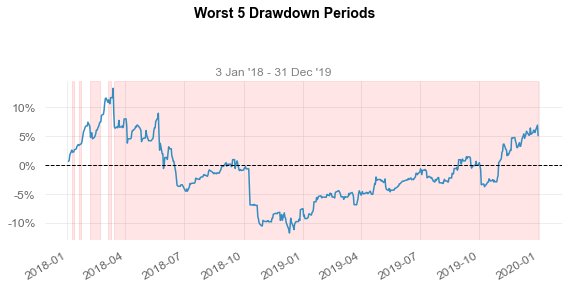

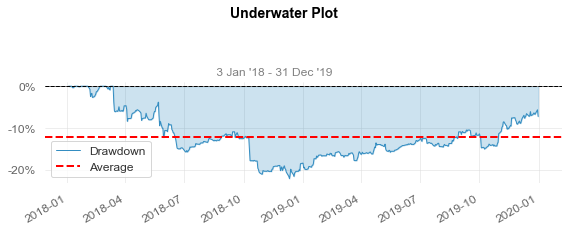

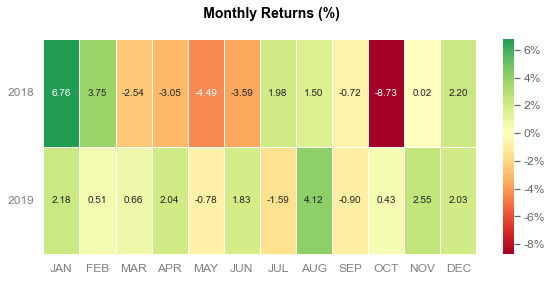

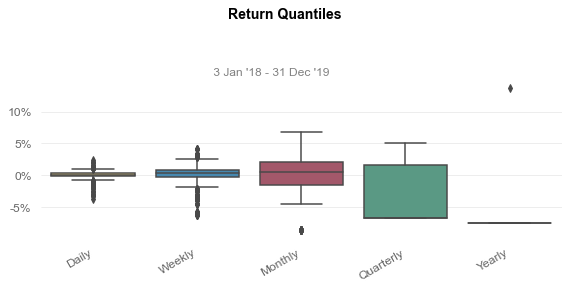

In [12]:
qs.extend_pandas()
new_worth = pd.Series(env.history["net_worth"], index=df[TICKERS[0]].index[val_start+1:val_end])
returns = new_worth.pct_change().iloc[1:]
qs.reports.full(returns)

# Consensus Model baseline

In [13]:
env = env_maker_val()
observation = env.reset()

c = 0
stock_ts = 0
cash_holding = []
while True:
    action = np.zeros(len(TICKERS) + 1, dtype=np.float)
    for i, ticker in enumerate(TICKERS):
        if np.all([directions_df[ticker].iloc[c][f"MODEL_{j+1}"] == 1. for j in range(10)]):
            action[i + 1] = 1.

    if np.sum(action[1:]) > 0:
        action[0] = 0
        stock_ts += 1
    else:
        action[0] = 1

    c += 1
    observation, reward, done, info = env.step(action)
    cash_holding.append(info["position"][0] / info["net_worth"])

    if done:
        print("Info:", info)
        print("Iterations:", c)
        break


print("Average cash:", np.mean(cash_holding) * 100)
print("Time steps with stock:", stock_ts / c * 100)

NESZ
CIMB
MAY
KLK
Continuous action space
Info: {'total_reward': 38819.31000000007, 'total_profit': 38819.31000000007, 'position': array([138819.31,      0.  ,      0.  ,      0.  ,      0.  ]), 'delta': array([138805.04,      0.  ,      0.  ,  -7962.  ,  -2764.  ]), 'net_worth': 138819.30999999997}
Iterations: 521
Average cash: 41.668118491712264
Time steps with stock: 58.34932821497121


                           Strategy
-------------------------  ----------
Start Period               2018-01-03
End Period                 2019-12-31
Risk-Free Rate             0.0%
Time in Market             49.0%

Cumulative Return          39.67%
CAGR﹪                     18.27%

Sharpe                     1.58
Smart Sharpe               1.57
Sortino                    2.19
Smart Sortino              2.18
Sortino/√2                 1.55
Smart Sortino/√2           1.54
Omega                      1.58

Max Drawdown               -8.9%
Longest DD Days            168
Volatility (ann.)          10.63%
Calmar                     2.05
Skew                       -2.17
Kurtosis                   28.78

Expected Daily %           0.06%
Expected Monthly %         1.4%
Expected Yearly %          18.18%
Kelly Criterion            23.16%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.04%
Expected Shortfall (cVaR)  -1.04%

Gain/Pain Ratio            0.58
Gain/Pain (1M)             4

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2019-09-18,2019-10-07,2019-11-07,50,-8.898986,-8.835779
2,2018-02-28,2018-04-04,2018-08-15,168,-6.663100,-5.808346
3,2019-02-27,2019-05-10,2019-07-01,124,-4.229490,-3.801975
4,2018-09-24,2018-09-25,2018-11-16,53,-2.950712,-2.794835
5,2019-07-10,2019-08-28,2019-09-04,56,-2.635579,-2.407312


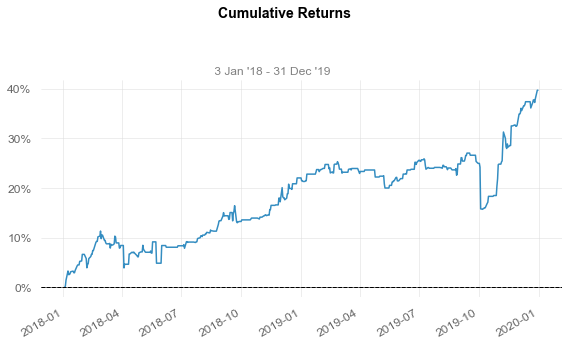

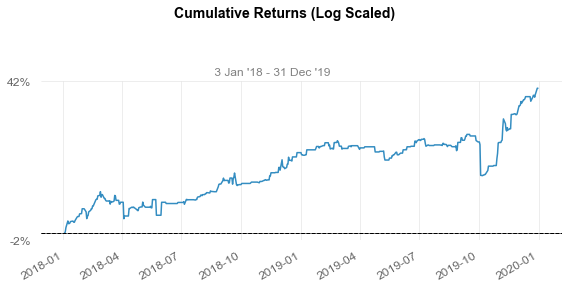

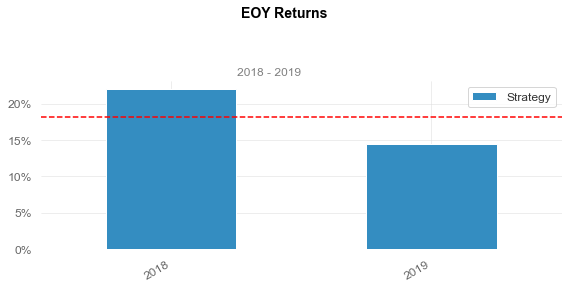

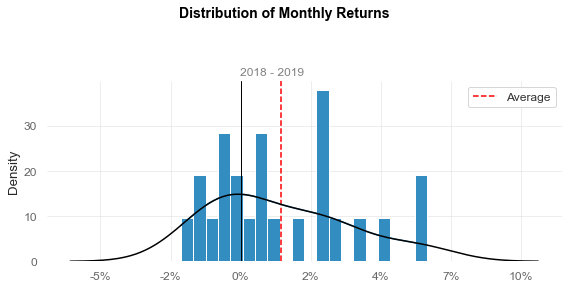

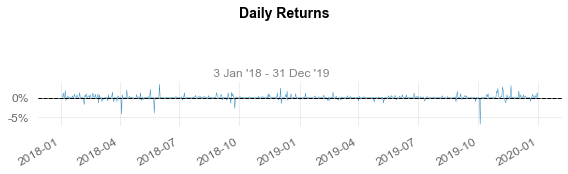

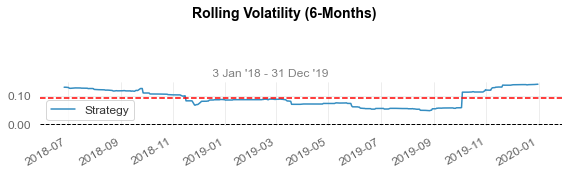

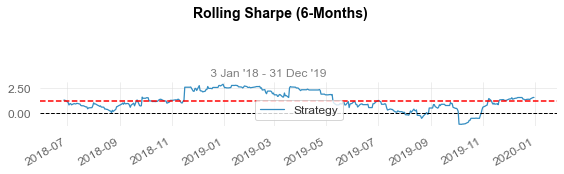

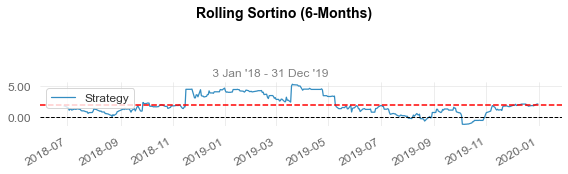

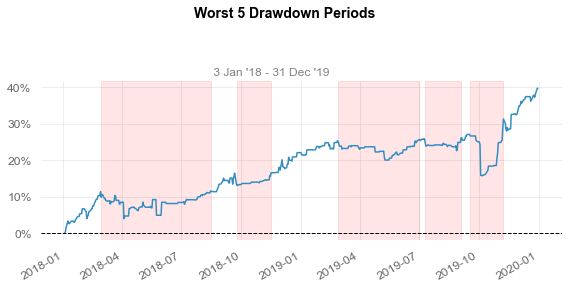

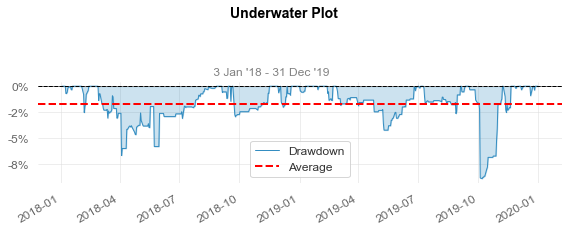

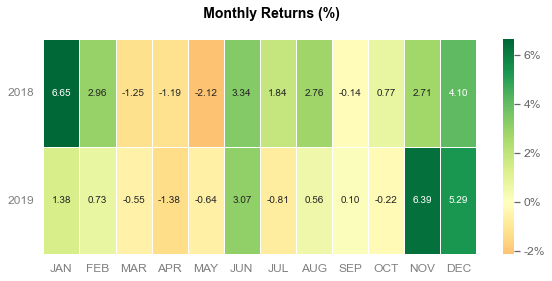

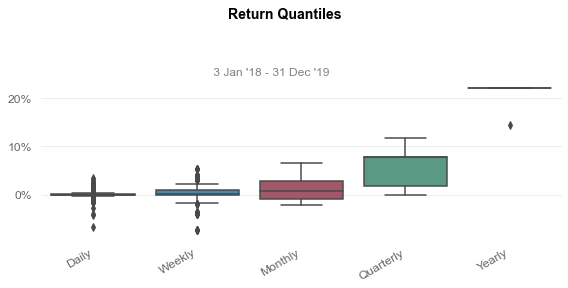

In [14]:
qs.extend_pandas()
new_worth = pd.Series(env.history["net_worth"], index=df[TICKERS[0]].index[val_start+1:val_end])
returns = new_worth.pct_change().iloc[1:]
qs.reports.full(returns)

# Proportional baseline

In [15]:
env = env_maker_val()
observation = env.reset()

c = 0
stock_ts = 0
cash_holding = []
while True:
    action = np.zeros(len(TICKERS) + 1, dtype=np.float)
    for i, ticker in enumerate(TICKERS):
        action[i + 1] = np.sum([1 if directions_df[ticker].iloc[c][f"MODEL_{j+1}"] == 1. else 0. for j in range(10)])
        action[i + 1] = max(action[i + 1] - 4, 0.)

    if np.sum(action[1:]) > 0:
        action[0] = 0
        stock_ts += 1
    else:
        action[0] = 1

    c += 1
    observation, reward, done, info = env.step(action)
    cash_holding.append(info["position"][0] / info["net_worth"])

    if done:
        print("Info:", info)
        print("Iterations:", c)
        break

print("Average cash:", np.mean(cash_holding) * 100)
print("Time steps with stock:", stock_ts / c * 100)

NESZ
CIMB
MAY
KLK
Continuous action space
Info: {'total_reward': 14681.150000000065, 'total_profit': 14681.150000000065, 'position': array([   8.76,    0.  , 8461.  , 3091.  , 1790.  ]), 'delta': array([  -26.77,     0.  ,  5347.  , -2660.  ,  -206.  ]), 'net_worth': 114681.15000000024}
Iterations: 521
Average cash: 3.5073160221203006
Time steps with stock: 96.54510556621881


                           Strategy
-------------------------  ----------
Start Period               2018-01-03
End Period                 2019-12-31
Risk-Free Rate             0.0%
Time in Market             88.0%

Cumulative Return          16.03%
CAGR﹪                     7.75%

Sharpe                     0.69
Smart Sharpe               0.63
Sortino                    0.92
Smart Sortino              0.85
Sortino/√2                 0.65
Smart Sortino/√2           0.6
Omega                      1.15

Max Drawdown               -16.9%
Longest DD Days            565
Volatility (ann.)          11.37%
Calmar                     0.46
Skew                       -1.08
Kurtosis                   8.14

Expected Daily %           0.03%
Expected Monthly %         0.62%
Expected Yearly %          7.72%
Kelly Criterion            7.64%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.15%
Expected Shortfall (cVaR)  -1.15%

Gain/Pain Ratio            0.15
Gain/Pain (1M)             0.73

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-05-23,2018-10-26,2019-12-09,565,-16.903315,-16.293601
2,2018-03-14,2018-05-07,2018-05-22,69,-6.386846,-6.364996
3,2018-02-05,2018-02-06,2018-02-20,15,-2.531524,-2.498329
4,2019-12-31,2019-12-31,2019-12-31,0,-1.830213,NaN
5,2018-03-05,2018-03-08,2018-03-12,7,-1.013377,-0.834277


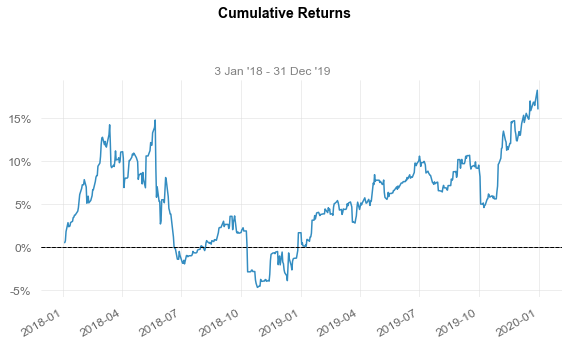

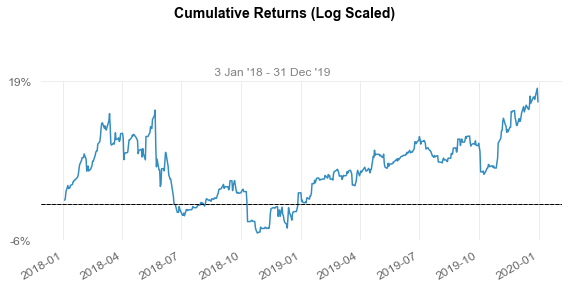

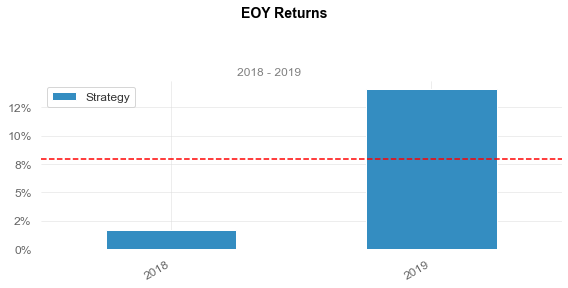

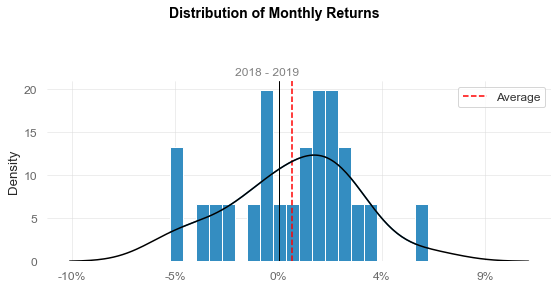

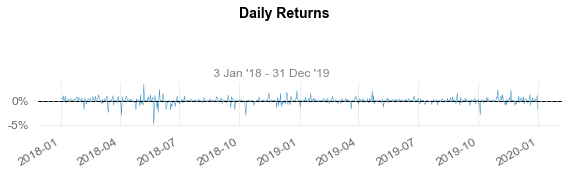

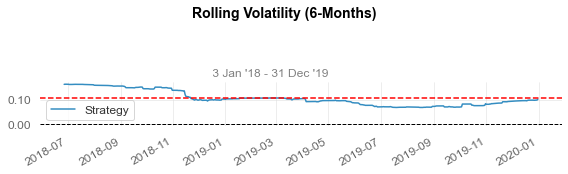

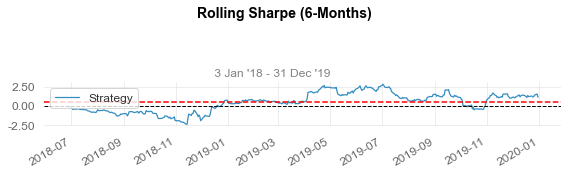

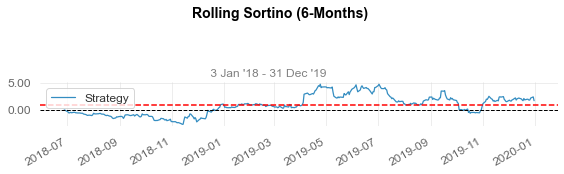

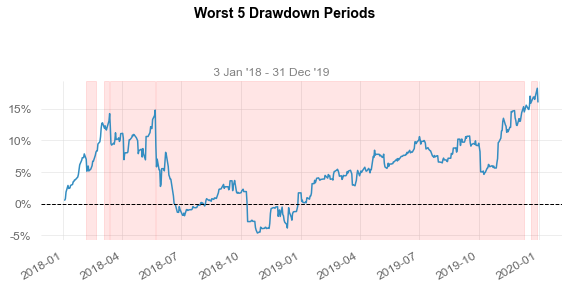

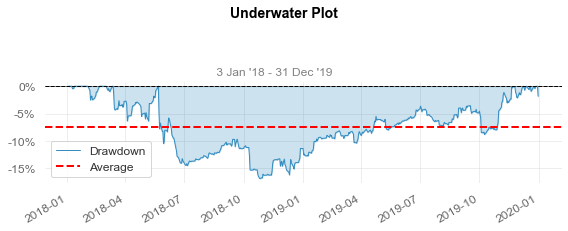

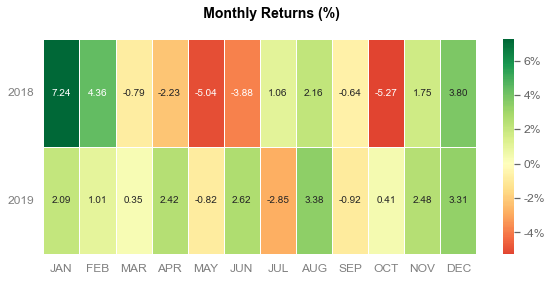

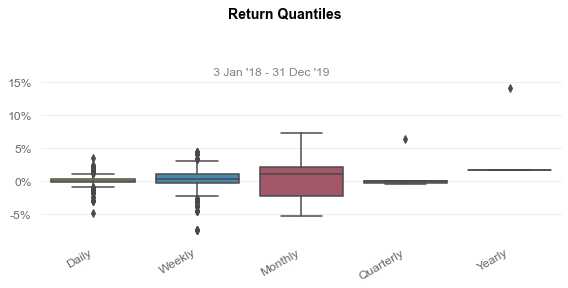

In [16]:
qs.extend_pandas()
new_worth = pd.Series(env.history["net_worth"], index=df[TICKERS[0]].index[val_start+1:val_end])
returns = new_worth.pct_change().iloc[1:]
qs.reports.full(returns)

# Need 8 model

In [17]:
env = env_maker_val()
observation = env.reset()

c = 0
stock_ts = 0
cash_holding = []
while True:
    action = np.zeros(len(TICKERS) + 1, dtype=np.float)
    for i, ticker in enumerate(TICKERS):
        n_models = np.sum([1 if directions_df[ticker].iloc[c][f"MODEL_{j+1}"] == 1. else 0. for j in range(10)])
        if n_models >= 8:
            action[i + 1] = 1.

    if np.sum(action[1:]) > 0:
        action[0] = 0
        stock_ts += 1
    else:
        action[0] = 1

    c += 1
    observation, reward, done, info = env.step(action)
    cash_holding.append(info["position"][0] / info["net_worth"])

    if done:
        print("Info:", info)
        print("Iterations:", c)
        break

print("Average cash:", np.mean(cash_holding) * 100)
print("Time steps with stock:", stock_ts / c * 100)

NESZ
CIMB
MAY
KLK
Continuous action space
Info: {'total_reward': 25900.66000000014, 'total_profit': 25900.66000000014, 'position': array([   26.51,     0.  , 12109.  ,     0.  ,  2561.  ]), 'delta': array([   19.93,     0.  , 12109.  , -7376.  ,     0.  ]), 'net_worth': 125900.66000000034}
Iterations: 521
Average cash: 19.419857971737926
Time steps with stock: 80.61420345489442


                           Strategy
-------------------------  ----------
Start Period               2018-01-03
End Period                 2019-12-31
Risk-Free Rate             0.0%
Time in Market             71.0%

Cumulative Return          27.59%
CAGR﹪                     13.01%

Sharpe                     1.18
Smart Sharpe               1.17
Sortino                    1.64
Smart Sortino              1.63
Sortino/√2                 1.16
Smart Sortino/√2           1.15
Omega                      1.31

Max Drawdown               -9.99%
Longest DD Days            182
Volatility (ann.)          10.46%
Calmar                     1.3
Skew                       -0.93
Kurtosis                   9.21

Expected Daily %           0.05%
Expected Monthly %         1.02%
Expected Yearly %          12.95%
Kelly Criterion            14.4%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.03%
Expected Shortfall (cVaR)  -1.03%

Gain/Pain Ratio            0.31
Gain/Pain (1M)             1.

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-03-05,2018-05-30,2018-09-03,182,-9.990639,-8.607219
2,2018-09-18,2018-10-29,2018-12-13,86,-4.718899,-4.565601
3,2019-09-27,2019-10-09,2019-11-01,35,-4.467920,-4.245266
4,2019-02-27,2019-05-13,2019-08-23,177,-3.681479,-3.480614
5,2018-02-05,2018-02-09,2018-02-20,15,-2.898486,-2.666203


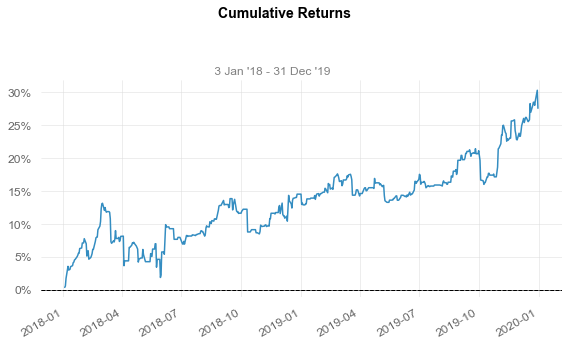

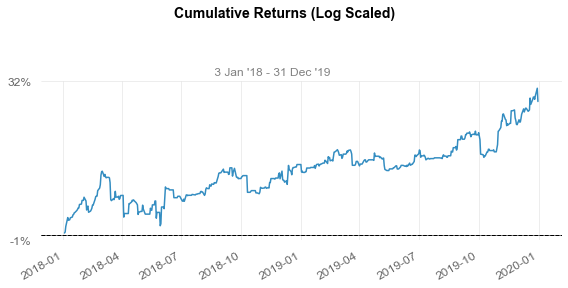

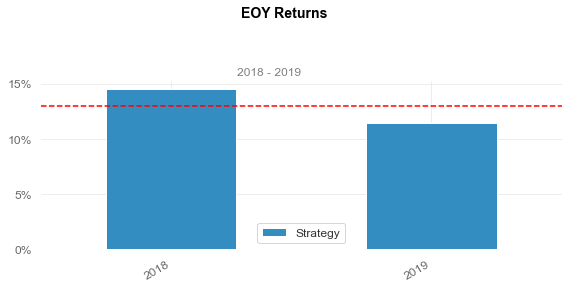

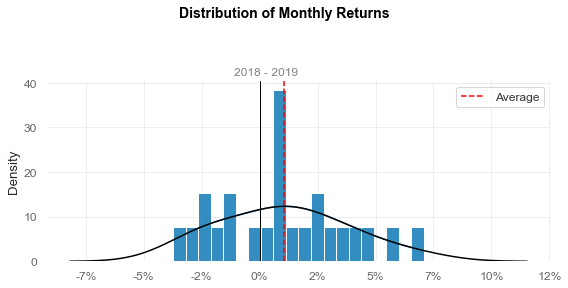

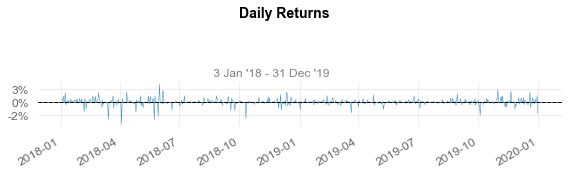

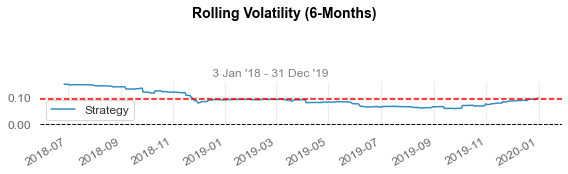

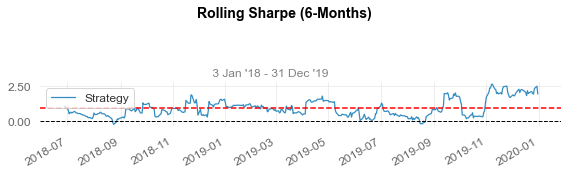

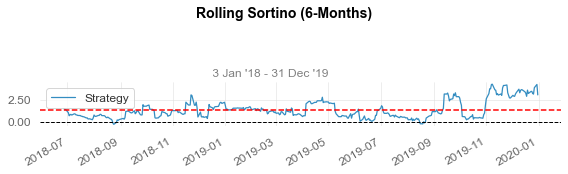

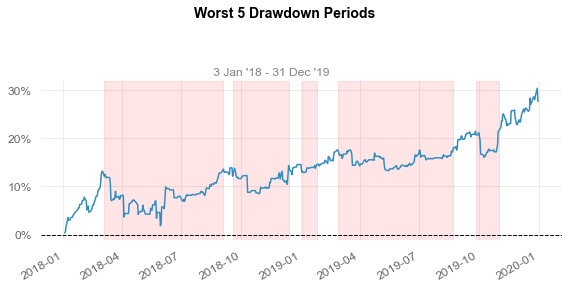

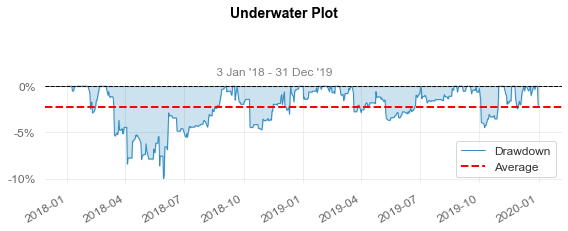

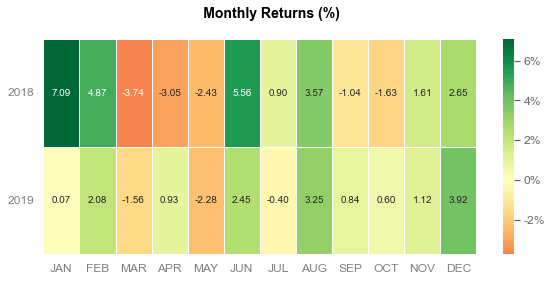

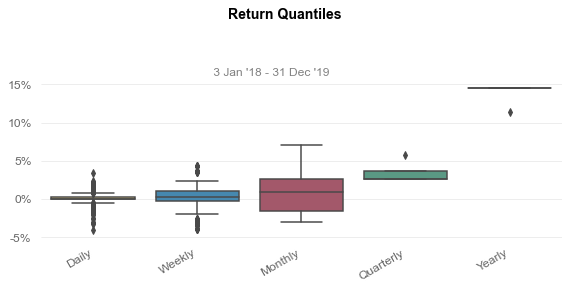

In [18]:
qs.extend_pandas()
new_worth = pd.Series(env.history["net_worth"], index=df[TICKERS[0]].index[val_start+1:val_end])
returns = new_worth.pct_change().iloc[1:]
qs.reports.full(returns)